<a href="https://colab.research.google.com/github/apof/Multi-Agent-AI/blob/main/VDQN_Switch_n_Gym.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!rm -rf /content/ma-gym  
!git clone https://github.com/koulanurag/ma-gym.git 
%cd /content/ma-gym 
!pip install -q -e . 
!apt-get install -y xvfb python-opengl x11-utils > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install x11-utils
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install -U gym[atari] > /dev/null 2>&1

Cloning into 'ma-gym'...
remote: Enumerating objects: 50, done.
remote: Counting objects: 100% (50/50), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 981 (delta 16), reused 32 (delta 8), pack-reused 931
Receiving objects: 100% (981/981), 3.72 MiB | 10.46 MiB/s, done.
Resolving deltas: 100% (479/479), done.
/content/ma-gym
Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.
Requirement already up-to-date: setuptools in /usr/local/lib/python3.7/dist-packages (54.1.2)


In [2]:
%matplotlib inline
import gym
import ma_gym
from ma_gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import time
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import random
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 200px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

**Random Policy Agent Below**

In [4]:
env = wrap_env(gym.make("Switch2-v0")) # Use "Switch4-v0" for the Switch-4 game

#### run the game for a number of episodes for a random policy
episodes_reward = []
cum_random_reward = []
episodes_list = []
episodes_num = 1000

for episode in range(episodes_num):

  episodes_list.append(episode)

  done_n = [False for _ in range(env.n_agents)]
  ep_reward = 0

  steps = 0

  obs_n = env.reset()
  while not all(done_n):
      steps += 1
      obs_n, reward_n, done_n, info = env.step(env.action_space.sample())
      ep_reward += sum(reward_n)
      #print(done_n)
      #print(steps)
  episodes_reward.append(ep_reward)
  cum_random_reward.append(sum(episodes_reward))

env.close()
# To improve the training efficiency, render() is not necessary during the training.
# We provide the render and video code here just want to demonstrate how to debugging and analysis.
show_video()

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [5]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [6]:
class DQN(nn.Module):
  def __init__(self):
    super().__init__()

    self.hidden_dim = 48
    self.linear_dim = 128
    self.n_layers = 1

    self.features_num = 4

    self.rnn_1 = nn.RNN(self.features_num,self.hidden_dim,self.n_layers,batch_first = True)

    self.value_stream_1 = nn.Sequential(
    nn.Linear(self.hidden_dim, self.linear_dim),
    nn.ReLU(),
    nn.Linear(self.linear_dim,1))

    self.advantage_stream_1 = nn.Sequential(
    nn.Linear(self.hidden_dim, self.linear_dim),
    nn.ReLU(),
    nn.Linear(self.linear_dim,5))

    self.rnn_2 = nn.RNN(self.features_num,self.hidden_dim,self.n_layers,batch_first = True)
    self.fc_2 = nn.Linear(self.hidden_dim,self.linear_dim)

    self.value_stream_2 = nn.Sequential(
    nn.Linear(self.hidden_dim, self.linear_dim),
    nn.ReLU(),
    nn.Linear(self.linear_dim,1))

    self.advantage_stream_2 = nn.Sequential(
    nn.Linear(self.hidden_dim, self.linear_dim),
    nn.ReLU(),
    nn.Linear(self.linear_dim,5))

  def forward(self,x_1,x_2):

    batch_size = x_1.size(0)

    hidden_1 = self.init_hidden(batch_size)
    hidden_2 = self.init_hidden(batch_size)

    ## first subnetwork related to agent 1
    out_1, hid_1 = self.rnn_1(x_1,hidden_1)
    rnn1_out = out_1[:,-1,:]
    values_1 = self.value_stream_1(rnn1_out)
    advantages_1 = self.advantage_stream_1(rnn1_out)
    qvals1 = values_1 + (advantages_1 - advantages_1.mean())

    ## first subnetwork related to agent 1
    out_2, hid_2 = self.rnn_2(x_2,hidden_2)
    rnn2_out = out_2[:,-1,:]
    values_2 = self.value_stream_2(rnn2_out)
    advantages_2 = self.advantage_stream_2(rnn2_out)
    qvals2 = values_2 + (advantages_2 - advantages_2.mean())

    joint_qval = torch.add(qvals1,qvals2)

    return [qvals1, qvals2], joint_qval

  def get_current(self,states_1,states_2,actions_1,actions_2):
    ## get the current action based on the policy network
    ## and then sum the action values for the two agents
    [qvals1,qvals2],_ = self.forward(states_1,states_2)
    ac_1 = qvals1.gather(dim=1, index=actions_1.unsqueeze(-1))
    ac_2 = qvals2.gather(dim=1, index=actions_2.unsqueeze(-1))
    return torch.add(ac_1,ac_2)
 
  def get_next(self,next_states_1,next_states_2,flg1,flg2):                
    ## given the next state return the max Q value output using the target network
    [qvals1,qvals2],_ = self.forward(next_states_1,next_states_2)
    joint_qval = torch.add(qvals1*flg1,qvals2*flg2)
    ## return the maximum joint action value
    return joint_qval.max(dim=1)[0].detach()

  def init_hidden(self,batch_size):
    return torch.zeros(self.n_layers,batch_size,self.hidden_dim)

In [7]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward','final')
)

In [8]:
## define a timeseries states length
state_timesteps = 3

In [9]:
class ReplayMemory():

    def __init__(self, capacity):
        ## the maximum capacity of the replay memory
        self.capacity = capacity
        ## the memory queue
        self.memory = []

    def push(self,experience):
      self.memory.append(experience)

    ## collect a random sample of experiences from the replay memory
    ## batch_size has to be <= capacity
    def sample(self, batch_size, indices = None):

      states = []
      actions = []
      rewards = []
      next_states =[]
      final_flags = []

      ## select batch_size number of indexes to sample from 
      if(len(self.memory) > self.capacity):
        self.memory = self.memory[-self.capacity:]

      if(indices == None):
        indexes = random.sample(range(0,len(self.memory) - state_timesteps), batch_size)
      else:
        indexes = indices

      ## create timeseries of experience replay
      for i in range(batch_size):
        state,action,reward,next_state,flag = self.give_timeseries_sample(indexes[i])

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        next_states.append(next_state)
        final_flags.append(flag)

      states = np.array(states)
      actions = np.array(actions)
      rewards = np.array(rewards)
      next_states = np.array(next_states)
      final_flags = np.array(final_flags)

      return states, actions, rewards, next_states, indexes, final_flags

    def give_timeseries_sample(self,start):

      end = start + state_timesteps
      memory = self.memory[start:end]
      t = Experience(*zip(*memory))

      state = []
      next_state = []

      flag = 0

      for i in range(len(t.state)):

          state.append(np.array(t.state[i]))
          next_state.append(np.array(t.next_state[i]))

          ## if a final state is included in the series
          if(i!= (len(t.state) -1) and t.final[i] == 1):
            flag = 1
          ## if a final state is the last step of the series
          elif(i == (len(t.state) -1) and t.final[i] == 1):
            flag = 2

      return (np.array(state),np.array(t.action[-1]),np.array(t.reward[-1]),np.array(next_state),flag)


    def get_last_timeseries_action(self):
      if(len(self.memory) >= state_timesteps):
        memory = self.memory[-state_timesteps:]
        t = Experience(*zip(*memory))
        state = []
        for i in range(len(t.state)):
          state.append(np.array(t.next_state[i]))
        return np.array(state)
      else:
        return None

    ## check if the replay memory can provide us with the minibatch we need
    def can_provide_sample(self, batch_size):
      return len(self.memory) >= (batch_size + state_timesteps)

In [10]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, current_step):
      return self.end + (self.start - self.end) * \
        math.exp(-1. * current_step * self.decay)

In [11]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.current_step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device
        self.episode_step = 0

    def reset_episode_step(self):
      self.episode_step = 0

    def select_action(self, state, policy_net, agent_index):
      
        ## get the exploration rate
        rate = self.strategy.get_exploration_rate(self.current_step)

        self.current_step += 1
        self.episode_step += 1

        ## select to exploit or exlore according to e-greedy strategy with decay
        if (rate > random.random() or self.episode_step < state_timesteps):
            ## explore and return a random action
            return random.randrange(self.num_actions)
        else:
            with torch.no_grad():
              # exploit and return an action based on the policy net
              state_tensor = torch.from_numpy(np.array(state))
              state_tensor = torch.unsqueeze(state_tensor, 0)
              qvals,_ = policy_net(state_tensor.float(),state_tensor.float())
              action = qvals[agent_index].argmax(dim=1).to(self.device).item()
              return action

In [12]:
class SwitchManager():

    def __init__(self, device, env_name):
        self.device = device
        self.env = gym.make(env_name).unwrapped
        self.env.reset()

    def reset(self):
        state = self.env.reset()
        return state

    def close(self):
        self.env.close()


    def num_actions_available(self):
        return self.env.action_space[0].n

    def take_action(self, action):        
        return self.env.step(action)  

In [13]:
## batch size (minibatch size to sample from the replay buffer)
batch_size = 128
## discount factor
gamma = 0.999
## params related to e-greedy strategy
eps_start = 1
eps_end = 0.01
eps_decay = 0.0001
## how often to update the target network
target_update = 10
## the size of the memory to remember
memory_size = 1000000
## learning rate of the nn
lr = 0.0001
## episodes to play
num_episodes = 2000
## number of agents
agents_num = 2

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
env_name = "Switch2-v0"
environment = SwitchManager(device,env_name)
strategy = EpsilonGreedyStrategy(eps_start, eps_end, eps_decay)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [16]:
agents = []
memories = []
policy_nets = []
target_nets = []
optimizers = []
for i in range(agents_num):
  agents.append(Agent(strategy, environment.num_actions_available(), device))
  memories.append(ReplayMemory(memory_size))

### define the policy and the target network
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
optimizer = optim.Adam(params=policy_net.parameters(), lr=lr)
##optimizer = optim.RMSprop(params=policy_net.parameters(), lr=lr)

In [17]:
def select_valid_data(states_list,next_state_list,action_list,reward_list,flag_list):

  final_state_list = [[],[]]
  final_next_state_list = [[],[]]
  final_action_list = [[],[]]
  final_reward_list = [[],[]]
  final_flag_list = [[],[]]

  for i in range(batch_size):

    if(flag_list[0][i] == 1 or flag_list[1][i] == 1):
      #print("ok1")
      continue
    else:

      final_state_list[0].append(states_list[0][i])
      final_state_list[1].append(states_list[1][i])
      final_next_state_list[0].append(next_state_list[0][i])
      final_next_state_list[1].append(next_state_list[1][i])
      final_action_list[0].append(action_list[0][i])
      final_action_list[1].append(action_list[1][i])
      final_reward_list[0].append(reward_list[0][i])
      final_reward_list[1].append(reward_list[1][i])

      arr1 = np.array([1,1,1,1,1])
      arr0 = np.array([0,0,0,0,0])

      if(flag_list[0][i] == 0 and flag_list[1][i] == 0):
        final_flag_list[0].append(arr1)
        final_flag_list[1].append(arr1)
        #print("ok2")
      elif(flag_list[0][i] == 0 and flag_list[1][i] == 2):
        final_flag_list[0].append(arr1)
        final_flag_list[1].append(arr0)
        #print("ok3")
      elif(flag_list[0][i] == 2 and flag_list[1][i] == 0):
        final_flag_list[0].append(arr0)
        final_flag_list[1].append(arr1)
        #print("ok4")
      elif(flag_list[0][i] == 2 and flag_list[1][i] == 2):
        final_flag_list[0].append(arr0)
        final_flag_list[1].append(arr0)
        #print("ok5")

  for i in range(2):
      final_state_list[i] = np.array(final_state_list[i])
      final_next_state_list[i] = np.array(final_next_state_list[i])
      rewards[i] = np.array(rewards[i])
      next_states[i] = np.array(next_states[i])
      flags[i] = np.array(flags[i])


  return np.array(final_state_list),  np.array(final_next_state_list), np.array(final_action_list), np.array(final_reward_list), np.array(final_flag_list)

In [18]:
def convert_to_tensors(states, actions, rewards, next_states, flags):
    return torch.from_numpy(states), torch.from_numpy(actions), torch.from_numpy(rewards), torch.from_numpy(next_states), torch.from_numpy(flags)

In [19]:
## for each episode
reward_list = []
episode_list = []
cum_reward = []

won_games = 0
partially_won_games = 0

win_list = []

for episode in range(num_episodes):

  for i in range(agents_num):
    agents[i].reset_episode_step()

  steps = 0

  episode_list.append(episode)
  done = [False for _ in range(agents_num)]
  ## reward for the specific episode
  eps_reward = 0
  ## reset the environment at the start of each episode
  state  = environment.reset()

  ## for each timestep of thee episode
  while (not all(done)):

    partial_win_flag = 0

    actions = []

    steps += 1

    ## for every agent
    for i in range(agents_num):
      ## select an action according to the policy net
      action = agents[i].select_action(memories[i].get_last_timeseries_action(), policy_net, i)
      actions.append(action)

    ## execute the actions and obtain the reward of the actions selected
    next_state, reward, done, info = environment.take_action(actions)
    eps_reward += sum(reward)

    for i in range(agents_num):
      ## save the experience to the replay memory
      state_features = [state[i][0], state[i][1], float(steps), float(i)]
      next_state_features = [next_state[i][0], next_state[i][1], float(steps+1), float(i)]
      memories[i].push(Experience(state_features, actions[i], next_state_features, sum(reward),int(done[i])))

    state = next_state

    st = []
    a = []
    nst = []
    re = []
    indices = None
    flags = []
    ## if the memory can provide us with a minibatch of experiences
    if memories[0].can_provide_sample(batch_size):

      for i in range(agents_num):
        ## get tensors of the components of the experience batch
        if(i==0):
          states, actions, rewards, next_states, ind , final_flags = memories[i].sample(batch_size)
          indices = ind
        else:
          states, actions, rewards, next_states, _ , final_flags = memories[i].sample(batch_size, indices)
        
        st.append(states)
        a.append(actions)
        re.append(rewards)
        nst.append(next_states)
        flags.append(final_flags)

      st, nst, a, re, flags = select_valid_data(st,nst,a,re,flags)

      st, a, re, nst, flags = convert_to_tensors(st, a, re, nst, flags)

      ## get the current Q values using the policy network
      current_q_values = policy_net.get_current(st[0].float(),st[1].float(),a[0],a[1])

      ## get the next Q values using the target network
      next_q_values = target_net.get_next(nst[0].float(),nst[1].float(),flags[0].float(), flags[1].float())

      ## compute the target Q values using bellman equation
      target_q_values = (next_q_values * gamma) + re[0]

      ## compute the loss
      loss = F.mse_loss(current_q_values.float(), target_q_values.unsqueeze(1).float())
      #loss = F.smooth_l1_loss(current_q_values.float(), target_q_values.unsqueeze(1).float())
      ## update the policy network
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      ## every a number of episodes update the target networks weights with the respective policy networks weights
      if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

  reward_list.append(eps_reward)
  cum_reward.append(sum(reward_list))

  if(steps < 50):
    won_games += 1
    win_list.append(2)
  elif(eps_reward > -7):
    win_list.append(1)
    partially_won_games += 1
  else:
    win_list.append(0)

  print("Episode's " + str(episode) + " reward is: " + str(eps_reward) + " games won " + str(won_games))
  clear_output(wait=True)
    
## close the environment after the training of the network
environment.close()

Episode's 1999 reward is: 6.4 games won 1667


In [20]:
print("Games won: " + str(won_games))
print("Games won by only one player: " + str(partially_won_games))

Games won: 1667
Games won by only one player: 212


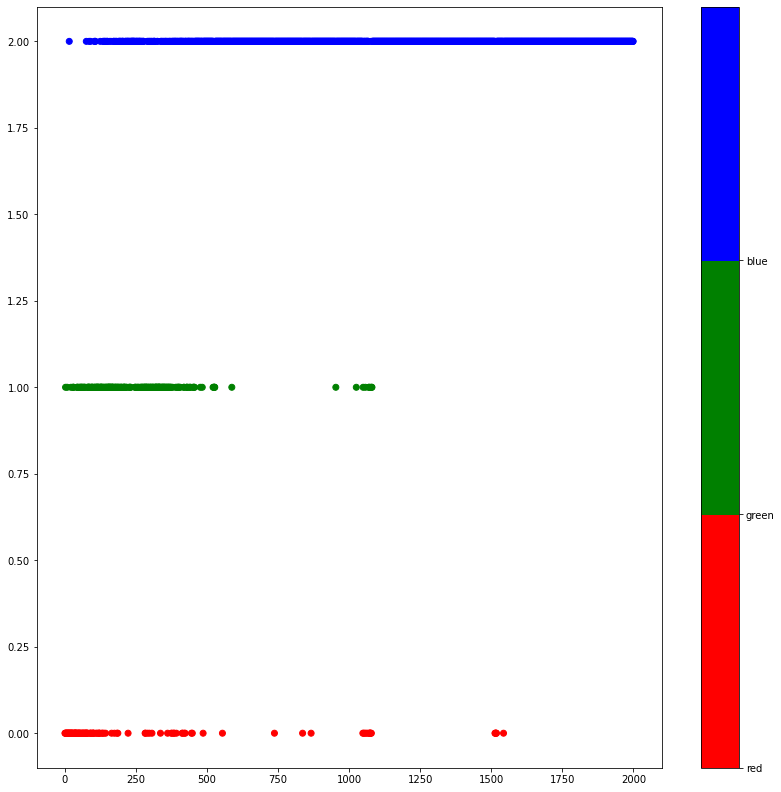

In [21]:
## visualise the wins per epidose

index = []
for i in range(num_episodes):
  index.append(i)

x = index
y = win_list
label = win_list
colors = ['red','green','blue']

fig = plt.figure(figsize=(14,14))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)

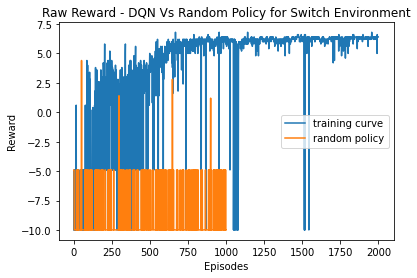

In [22]:
train_plot=plt.plot(episode_list,reward_list,label="training curve")
random_policy=plt.plot(episodes_list,episodes_reward,label="random policy")
plt.legend()
plt.title("Raw Reward - DQN Vs Random Policy for Switch Environment")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.show()

In [23]:
## compute smoothed reward (moving average of the cummulative reward)
training_smoothed_reward = []
window = 10
start = 0
end = window
for i in range(len(reward_list)):
  training_smoothed_reward.append(np.mean(np.array(reward_list[start:end])))
  start += 1
  end += 1

random_smoothed_reward = []
window = 40
start = 0
end = window
for i in range(len(episodes_reward)):
  random_smoothed_reward.append(np.mean(np.array(episodes_reward[start:end])))
  start += 1
  end += 1

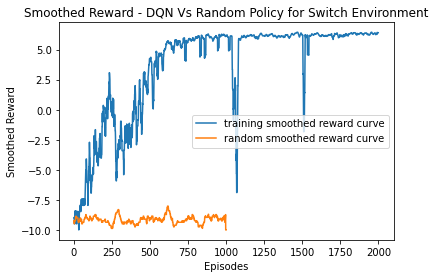

In [24]:
train_plot=plt.plot(episode_list,training_smoothed_reward,label="training smoothed reward curve")
random_policy=plt.plot(episodes_list,random_smoothed_reward,label="random smoothed reward curve")
plt.legend()
plt.title("Smoothed Reward - DQN Vs Random Policy for Switch Environment")
plt.xlabel("Episodes")
plt.ylabel("Smoothed Reward")
plt.show()

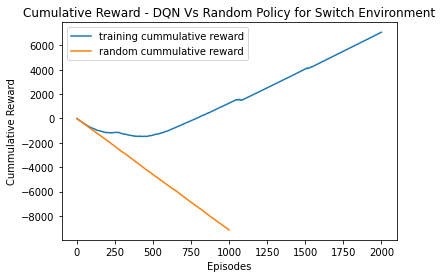

In [25]:
train_plot=plt.plot(episode_list,cum_reward,label="training cummulative reward")
random_policy=plt.plot(episodes_list,cum_random_reward,label="random cummulative reward")
plt.legend()
plt.title("Cumulative Reward - DQN Vs Random Policy for Switch Environment")
plt.xlabel("Episodes")
plt.ylabel("Cummulative Reward")
plt.show()